# Federated Mnist tests

take a look at this link: https://github.com/nicolagulmini/federated_learning#federated_fashion_mnist_x

Author: Nicola Gulmini (nicolagulmini@gmail.com)

# Modules and parameters

In [1]:
!rm -r federated_learning
!git clone git://github.com/nicolagulmini/federated_learning

Cloning into 'federated_learning'...
remote: Enumerating objects: 80250, done.
remote: Counting objects: 100% (37384/37384), done.
remote: Compressing objects: 100% (37276/37276), done.
remote: Total 80250 (delta 481), reused 36849 (delta 107), pack-reused 42866
Receiving objects: 100% (80250/80250), 72.01 MiB | 34.07 MiB/s, done.
Resolving deltas: 100% (645/645), done.
Checking out files: 100% (102080/102080), done.


In [2]:
# from github
from federated_learning.utils import *
from federated_learning.aggregator import *

# other libraries
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from skimage import io
from skimage import transform
import pandas as pd
from numpy import array
from numpy import argmax
from numpy import swapaxes
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from random import choice

In [3]:
# PARAMETERS
number_of_users = 45
number_of_clusters = 9

communication_rounds = 100
TRAINED = True

# Initialization of the setup and the datasets

In [4]:
# definition of the setup with the central server and its datasets
server = server()
server.model = define_model_mnist().model
fed_setup = federated_setup(server)
fed_setup.server_side_dataset_generator(600, 200, dataset='fashion')

Server dataset setting completed.


In [5]:
# initialization of the clusters with the users assigned. This is the method that creates the setup, returning a list of clusters with no data
clusters = fed_setup.initialize_users_to_clusters(number_of_users, number_of_clusters)

Cluster number 0. User ids: [0, 1, 2, 3, 4]
Cluster number 1. User ids: [5, 6, 7, 8, 9]
Cluster number 2. User ids: [10, 11, 12, 13, 14]
Cluster number 3. User ids: [15, 16, 17, 18, 19]
Cluster number 4. User ids: [20, 21, 22, 23, 24]
Cluster number 5. User ids: [25, 26, 27, 28, 29]
Cluster number 6. User ids: [30, 31, 32, 33, 34]
Cluster number 7. User ids: [35, 36, 37, 38, 39]
Cluster number 8. User ids: [40, 41, 42, 43, 44]


Dataset load, rotating some images to make the learning more challenging

In [6]:
# take the images and the .csv labels from the dataset to numpy arrays

clusters_train_data, clusters_test_data = [], []
datapath = "federated_learning/federated_fashion_mnist/federated_fashion_mnist_80/"
for i in range(number_of_clusters):
    cluster_data_path = datapath + str(i)
    train_path = cluster_data_path + "/training_images/"
    test_path = cluster_data_path + "/test_images/"
    ytrain = pd.read_csv(cluster_data_path + "/training_labels.csv", header=None, usecols=[1]).to_numpy().reshape(-1)
    ytest = pd.read_csv(cluster_data_path + "/test_labels.csv", header=None, usecols=[1]).to_numpy().reshape(-1)
    xtrain, xtest = [], []
    for img in range(len(ytrain)):
        xtrain.append(transform.rotate(io.imread(train_path + str(img) + ".png", as_gray=True), choice([0, 90, 180, 270])))
    for img in range(len(ytest)):
        xtest.append(transform.rotate(io.imread(test_path + str(img) + ".png", as_gray=True), choice([0, 90, 180, 270])))
    xtrain = array(xtrain)
    xtest = array(xtest)
    ytrain = array(ytrain)
    ytest = array(ytest)
    clusters_train_data.append({'cluster': i, 'images': xtrain, 'labels': ytrain})
    clusters_test_data.append({'cluster': i, 'images': xtest, 'labels': ytest})

In [7]:
# these methods assign data from the just loaded dataset to the clusters, and then from each cluster to its users
fed_setup.assign_dataset_to_clusters(clusters_train_data, clusters_test_data)
fed_setup.assign_clusters_data_to_users(verbose=0)

# initialize clusters models
for cluster in fed_setup.list_of_clusters:
    cluster.initialize_models()
    for user in cluster.users:
        user.initialize_classification_model()
    # then to transfer the cluster model to its users the transfer_cluster_model_to_users() method has to be used

# propagate from server to clusters the initial classification model
fed_setup.server_to_cluster_classification() # useless if local_updates=True then

Set data for cluster 0
Set data for cluster 1
Set data for cluster 2
Set data for cluster 3
Set data for cluster 4
Set data for cluster 5
Set data for cluster 6
Set data for cluster 7
Set data for cluster 8
Done.


In [8]:
fed_setup.local_epochs = 4

In [ ]:
if not TRAINED:
    # to plot
    #server_aggregator_performance = []
    genie_perf = [fed_setup.genie()]
    #local_acc = []
    global_avg_softmax = [fed_setup.global_acc_of_avg_softmax_model()]
    server_global_acc = [fed_setup.server.model.evaluate(fed_setup.server.x_test, fed_setup.server.y_test, verbose=0)[1]]
    server_avg_local_acc = []
    avg_local_local_models = []
    avg_local_avg_softmax = [fed_setup.avg_softmax_on_local_datasets()]

    # other metrics
    tmp_server_local_acc = 0
    tmp_acc = 0
    for cluster in fed_setup.list_of_clusters:
        tmp_server_local_acc += fed_setup.server.model.evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
        tmp_acc += cluster.get_model().evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
    server_avg_local_acc.append(tmp_server_local_acc/len(fed_setup.list_of_clusters))
    avg_local_local_models.append(tmp_acc/len(fed_setup.list_of_clusters))

    # training
    print("\nStart training.\n")
    for round in range(communication_rounds):

        print("\n****** COMMUNICATION ROUND NUMBER " + str(round) + " START ******\n")
        # train
        avg_local_local_models_acc, tmp_server_global_acc = fed_setup.clustered_fed_avg_one_shot(local_updates=False)

        # returned metrics
        server_global_acc.append(tmp_server_global_acc)
        avg_local_local_models.append(avg_local_local_models_acc)

        # other metrics
        genie_perf.append(fed_setup.genie())
        global_avg_softmax.append(fed_setup.global_acc_of_avg_softmax_model())
        avg_local_avg_softmax.append(fed_setup.avg_softmax_on_local_datasets())

        # server model local performances
        tmp_server_local_acc = 0
        for cluster in fed_setup.list_of_clusters:
            tmp_server_local_acc += fed_setup.server.model.evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
        server_avg_local_acc.append(tmp_server_local_acc/len(fed_setup.list_of_clusters))

    for cluster in fed_setup.list_of_clusters:
        cluster.get_model().save("final_cluster_model_" + str(cluster.number) + ".h5")

else:
    # load already trained models
    for cluster in fed_setup.list_of_clusters:
        cluster.model = models.load_model("./federated_learning/federated_fashion_mnist/100_rounds_80_heterogeneity_trained_local_models/final_cluster_model_"+str(cluster.number)+".h5")

# Aggregator

In [17]:
# define the aggregator
# Attention based aggregator
server_agg = attention_based_aggregator(len(fed_setup.list_of_clusters))

(x_train, y_train), (x_val, y_val), (x_test, y_test) = server_agg.produce_datasets(fed_setup)
epochs = 100
server_agg_acc, server_agg_loss, server_agg_val_acc, server_agg_val_loss = server_agg.train(x_train, y_train, x_val, y_val, 0, epochs)
server_acc = server_agg.evaluate(x_test, y_test, 0)

## Check the parameters

In [ ]:
#activation_model = Model(inputs=server_agg.model.input, outputs=server_agg.model.layers[2].output) # Creates a model that will return these outputs, given the model input

In [19]:
import numpy
# change them!
'''
cluster_favourite_labels = {0: 7, 
                            1: 6,
                            2: 2,
                            3: 5,
                            4: 5,
                            5: 9,
                            6: 8,
                            7: 5,
                            8: 7,
                        }

classes = [array([0.0 for _ in range(9)]) for __ in range(10)]
classes_count = [0 for _ in range(10)]
for i in range(len(fed_setup.server.x_train)):
    label = argmax(fed_setup.server.y_train[i])
    tmp_vector = activation_model.predict([fed_setup.server.x_train[i].reshape((1, 28, 28)), numpy.array([0])])[0]
    classes[label] += tmp_vector
    classes_count[label] += 1

cluster_with_that_label = [[] for _ in range(10)]
for label in range(10):
    for i in range(9):
        if cluster_favourite_labels[i] == label:
            cluster_with_that_label[label].append(i)
'''

'\ncluster_favourite_labels = {0: 7, \n                            1: 6,\n                            2: 2,\n                            3: 5,\n                            4: 5,\n                            5: 9,\n                            6: 8,\n                            7: 5,\n                            8: 7,\n                        }\n\nclasses = [array([0.0 for _ in range(9)]) for __ in range(10)]\nclasses_count = [0 for _ in range(10)]\nfor i in range(len(fed_setup.server.x_train)):\n    label = argmax(fed_setup.server.y_train[i])\n    tmp_vector = activation_model.predict([fed_setup.server.x_train[i].reshape((1, 28, 28)), numpy.array([0])])[0]\n    classes[label] += tmp_vector\n    classes_count[label] += 1\n\ncluster_with_that_label = [[] for _ in range(10)]\nfor label in range(10):\n    for i in range(9):\n        if cluster_favourite_labels[i] == label:\n            cluster_with_that_label[label].append(i)\n'

In [20]:
'''
for label in range(10):
    print('Class', label)
    print('clusters with that class:', cluster_with_that_label[label])
    plt.figure()
    if len(cluster_with_that_label[label]) == 0:
        name = 'no one'
    else:
        name = str(cluster_with_that_label[label])
    plt.plot(range(9), classes[label]/classes_count[label], label=str(label)+", clusters: "+name)
    for x in cluster_with_that_label[label]:
        plt.axvline(x=float(x), color='red')
    plt.legend(loc='lower right')
    plt.savefig(str(label)+'.png')
    print()
'''

'\nfor label in range(10):\n    print(\'Class\', label)\n    print(\'clusters with that class:\', cluster_with_that_label[label])\n    plt.figure()\n    if len(cluster_with_that_label[label]) == 0:\n        name = \'no one\'\n    else:\n        name = str(cluster_with_that_label[label])\n    plt.plot(range(9), classes[label]/classes_count[label], label=str(label)+", clusters: "+name)\n    for x in cluster_with_that_label[label]:\n        plt.axvline(x=float(x), color=\'red\')\n    plt.legend(loc=\'lower right\')\n    plt.savefig(str(label)+\'.png\')\n    print()\n'

# Plot performance

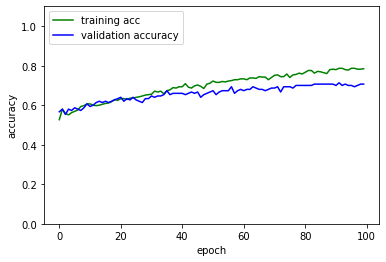

In [21]:
plt.figure()
plt.plot(range(epochs), server_agg_acc, label='training acc', color='green')
plt.plot(range(epochs), server_agg_val_acc, label='validation accuracy', color='blue')

plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
#plt.xlim(0, server_epochs+1)
plt.ylim(0, 1.1)
plt.savefig('server_aggregator_acc.png')

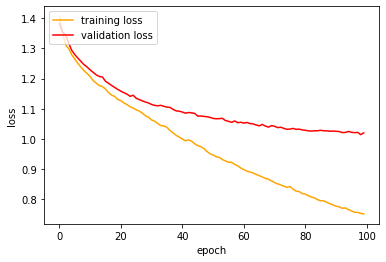

In [22]:
plt.figure()
plt.plot(range(epochs), server_agg_loss, label='training loss', color='orange')
plt.plot(range(epochs), server_agg_val_loss, label='validation loss', color='red')

plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.xlim(-.5, server_epochs+1)
plt.savefig('server_aggregator_loss.png')

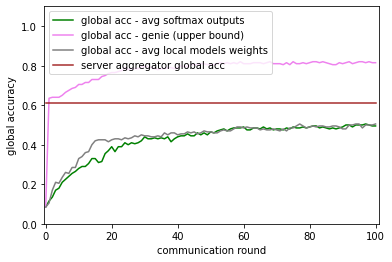

In [23]:
plt.figure()
plt.plot(range(communication_rounds+1), [0.085, 0.115, 0.135, 0.17, 0.18, 0.21, 0.225, 0.24, 0.255, 0.265, 0.28, 0.29, 0.29, 0.305, 0.33, 0.33, 0.31, 0.315, 0.355, 0.37, 0.39, 0.365, 0.39, 0.39, 0.41, 0.4, 0.41, 0.405, 0.41, 0.42, 0.44, 0.43, 0.43, 0.435, 0.43, 0.435, 0.43, 0.44, 0.415, 0.43, 0.44, 0.445, 0.445, 0.455, 0.445, 0.445, 0.46, 0.45, 0.46, 0.45, 0.465, 0.46, 0.47, 0.475, 0.48, 0.47, 0.48, 0.485, 0.485, 0.485, 0.49, 0.475, 0.475, 0.485, 0.485, 0.48, 0.49, 0.48, 0.485, 0.475, 0.48, 0.48, 0.475, 0.485, 0.48, 0.49, 0.485, 0.485, 0.49, 0.485, 0.49, 0.495, 0.495, 0.485, 0.49, 0.485, 0.48, 0.485, 0.48, 0.485, 0.49, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.505, 0.5, 0.495, 0.495], label='global acc - avg softmax outputs', color='green')
plt.plot(range(communication_rounds+1), [0.085, 0.635, 0.64, 0.64, 0.64, 0.65, 0.665, 0.675, 0.685, 0.69, 0.705, 0.705, 0.715, 0.715, 0.73, 0.73, 0.73, 0.745, 0.75, 0.76, 0.765, 0.765, 0.77, 0.775, 0.79, 0.78, 0.785, 0.785, 0.785, 0.795, 0.795, 0.795, 0.79, 0.785, 0.78, 0.785, 0.785, 0.79, 0.79, 0.785, 0.79, 0.8, 0.795, 0.795, 0.805, 0.805, 0.805, 0.81, 0.81, 0.805, 0.805, 0.805, 0.81, 0.815, 0.81, 0.815, 0.81, 0.815, 0.81, 0.82, 0.81, 0.81, 0.81, 0.815, 0.815, 0.815, 0.81, 0.815, 0.82, 0.81, 0.81, 0.81, 0.805, 0.815, 0.805, 0.82, 0.81, 0.81, 0.815, 0.81, 0.815, 0.82, 0.82, 0.815, 0.82, 0.815, 0.81, 0.805, 0.805, 0.815, 0.81, 0.815, 0.82, 0.81, 0.815, 0.82, 0.82, 0.815, 0.82, 0.815, 0.815], label='global acc - genie (upper bound)', color='violet')
plt.plot(range(communication_rounds+1), [0.08500000089406967, 0.10499999672174454, 0.17000000178813934, 0.20999999344348907, 0.20499999821186066, 0.23499999940395355, 0.25999999046325684, 0.2549999952316284, 0.2849999964237213, 0.2849999964237213, 0.33000001311302185, 0.3400000035762787, 0.36000001430511475, 0.36500000953674316, 0.4000000059604645, 0.41999998688697815, 0.42500001192092896, 0.42500001192092896, 0.42500001192092896, 0.41499999165534973, 0.42500001192092896, 0.4300000071525574, 0.4300000071525574, 0.42500001192092896, 0.4350000023841858, 0.4300000071525574, 0.4350000023841858, 0.4449999928474426, 0.4399999976158142, 0.44999998807907104, 0.4449999928474426, 0.4449999928474426, 0.4399999976158142, 0.4399999976158142, 0.4449999928474426, 0.4399999976158142, 0.46000000834465027, 0.44999998807907104, 0.46000000834465027, 0.46000000834465027, 0.44999998807907104, 0.45500001311302185, 0.45500001311302185, 0.4650000035762787, 0.46000000834465027, 0.4650000035762787, 0.45500001311302185, 0.46000000834465027, 0.4699999988079071, 0.4650000035762787, 0.4650000035762787, 0.46000000834465027, 0.46000000834465027, 0.4699999988079071, 0.4749999940395355, 0.4699999988079071, 0.4699999988079071, 0.47999998927116394, 0.49000000953674316, 0.49000000953674316, 0.48500001430511475, 0.49000000953674316, 0.48500001430511475, 0.48500001430511475, 0.48500001430511475, 0.4749999940395355, 0.47999998927116394, 0.4749999940395355, 0.4749999940395355, 0.47999998927116394, 0.4749999940395355, 0.4699999988079071, 0.47999998927116394, 0.4699999988079071, 0.48500001430511475, 0.48500001430511475, 0.4950000047683716, 0.5049999952316284, 0.4950000047683716, 0.48500001430511475, 0.49000000953674316, 0.4950000047683716, 0.49000000953674316, 0.4950000047683716, 0.4950000047683716, 0.49000000953674316, 0.49000000953674316, 0.4950000047683716, 0.4950000047683716, 0.49000000953674316, 0.47999998927116394, 0.47999998927116394, 0.5, 0.5, 0.5049999952316284, 0.5049999952316284, 0.48500001430511475, 0.5, 0.5, 0.5, 0.5049999952316284], label='global acc - avg local models weights', color='grey')
plt.plot(range(communication_rounds+1), [server_acc for _ in range(communication_rounds+1)], label='server aggregator global acc', color='brown')

plt.legend(loc="upper left")
plt.xlabel("communication round")
plt.ylabel("global accuracy")
plt.xlim(-.5, communication_rounds+1)
plt.ylim(0, 1.1)
plt.savefig('global.png')

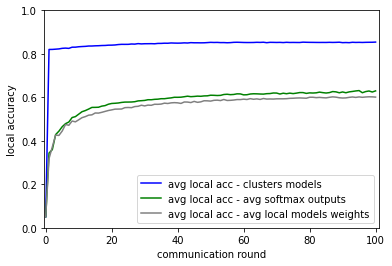

In [24]:
plt.figure()

plt.plot(range(communication_rounds+1), [0.050828605683313474, 0.8201534748077393, 0.820375919342041, 0.8214881420135498, 0.8227115869522095, 0.8253809213638306, 0.8263819217681885, 0.8251584768295288, 0.8306083679199219, 0.8307195901870728, 0.8326103687286377, 0.8336113691329956, 0.8343899316257899, 0.8359470566113789, 0.8360582788785298, 0.8369480570157368, 0.8373929527070787, 0.8382827242215474, 0.838616391023, 0.8398398359616597, 0.8400622871186998, 0.8408408429887559, 0.8427316215303209, 0.8437326285574172, 0.8436213996675279, 0.8437326285574172, 0.8452897402975295, 0.8447336223390367, 0.8470692965719435, 0.845734629366133, 0.8465131852361891, 0.84662440750334, 0.8468468520376418, 0.8462907407018874, 0.8479590747091506, 0.8480702969763014, 0.8489600751135085, 0.8487376305792067, 0.8500722977850173, 0.8495161864492629, 0.8491825196478102, 0.8495161864492629, 0.8505171868536208, 0.8498498532507155, 0.851518193880717, 0.8508508536550734, 0.8508508602778118, 0.8506284091207716, 0.8508508536550734, 0.8517406317922804, 0.8528528610865276, 0.8522967431280348, 0.8526304099294875, 0.8517406317922804, 0.8518518540594313, 0.8510732981893752, 0.8516294095251296, 0.8529640767309401, 0.8532977435323927, 0.8528528544637892, 0.8522967431280348, 0.8520742985937331, 0.8520742985937331, 0.8522967431280348, 0.853075298998091, 0.8526304099294875, 0.8534089657995436, 0.8512957427236769, 0.8529640767309401, 0.8527416321966383, 0.8524079720179241, 0.8527416321966383, 0.8518518540594313, 0.853075298998091, 0.8522967431280348, 0.8525191876623366, 0.8522967431280348, 0.852185520860884, 0.8537426326009963, 0.8531865212652419, 0.8528528610865276, 0.8527416388193767, 0.8525191942850749, 0.8524079720179241, 0.8525191876623366, 0.8524079653951857, 0.8529640833536785, 0.8525191876623366, 0.8528528544637892, 0.8535201880666945, 0.8515181872579787, 0.8520743052164714, 0.8514069649908278, 0.8531865278879802, 0.8525191942850749, 0.8528528610865276, 0.8524079720179241, 0.8529640833536785, 0.8531865278879802, 0.8532977501551311, 0.8540763060251872], label='avg local acc - clusters models', color='blue')
plt.plot(range(communication_rounds+1), [0.05082860638416195, 0.3437882326771216, 0.3595818040262485, 0.42853965076187295, 0.4444444444444444, 0.4649093537982427, 0.4789233678122567, 0.48637526415304194, 0.5070626181737292, 0.5112890668446224, 0.5226337448559671, 0.5338672005338672, 0.5390946502057612, 0.5459904348793239, 0.5536647758869981, 0.5538872205538872, 0.5544433322211101, 0.5595595595595595, 0.5620064508953397, 0.5683461239016795, 0.5717940162384606, 0.5726837949060171, 0.5740184629073518, 0.5765765765765766, 0.5781336892448002, 0.578244911578245, 0.5785785785785786, 0.5799132465799133, 0.5835835835835836, 0.5845845845845845, 0.5858080302524747, 0.5890334779223668, 0.5889222555889223, 0.5908130352574797, 0.5915915915915916, 0.5937048159270382, 0.5937048159270382, 0.5958180402624847, 0.597486375264153, 0.600266933600267, 0.6001557112668223, 0.6007118229340452, 0.6028250472694917, 0.605271938605272, 0.6030474919363809, 0.6040484929373817, 0.605494383272161, 0.6048270492714938, 0.606495384273162, 0.6069402736069403, 0.6097208319430542, 0.6092759426092761, 0.6083861639417195, 0.6090534979423868, 0.6130575019463909, 0.6141697252808364, 0.6122789456122789, 0.61327994661328, 0.6160605049493939, 0.6157268379490602, 0.6113891669447225, 0.6119452786119451, 0.6152819486152821, 0.6163941719497275, 0.6160605049493939, 0.615281948615282, 0.6148370592815037, 0.6168390612835056, 0.6173951729507284, 0.6199532866199533, 0.6196196196196195, 0.6152819486152821, 0.6189522856189522, 0.6166166166166166, 0.619285952619286, 0.6171727282838395, 0.6192859526192859, 0.6219552886219553, 0.6218440662885106, 0.6181737292848405, 0.620509398287176, 0.6198420642865088, 0.6207318429540651, 0.6239572906239572, 0.6216216216216216, 0.6198420642865089, 0.6217328439550661, 0.6265154042931821, 0.6251807362918473, 0.6209542876209544, 0.6247358469580693, 0.6210655099543989, 0.6250695139584029, 0.6270715159604048, 0.6294071849627405, 0.6310755199644089, 0.6211767322878434, 0.6265154042931821, 0.6291847402958514, 0.62451340229118, 0.6296296296296295], label='avg local acc - avg softmax outputs', color='green')
plt.plot(range(communication_rounds+1), [0.050828605683313474, 0.3182070907205343, 0.3719274749358495, 0.4264264189534717, 0.42475808246268165, 0.44511176894108456, 0.47514179431729847, 0.47147147274679607, 0.49104660004377365, 0.4872650346822209, 0.4967189356684685, 0.5065064976612726, 0.5112890609436564, 0.5179624118738704, 0.5195195161634021, 0.5279724051554998, 0.5275275193982654, 0.5310866443647279, 0.5353130814101961, 0.5394283069504632, 0.5423200908634398, 0.545656755566597, 0.5459904372692108, 0.5463240991036097, 0.5525525493754281, 0.5533311069011688, 0.5525525510311127, 0.5575575563642714, 0.5587809979915619, 0.5636747777462006, 0.5605605559216605, 0.5642308907376395, 0.5633411109447479, 0.5681236684322357, 0.5679012272093031, 0.5690134515364965, 0.5732398960325453, 0.5716827859481176, 0.5745745632383559, 0.575575566954083, 0.5746857937839296, 0.5720164560609393, 0.5785785698228412, 0.5782449063327577, 0.575909232099851, 0.5813591265016131, 0.5770214580827289, 0.5791346811585956, 0.584250905447536, 0.5839172386460834, 0.5826937970187929, 0.5862529062562518, 0.587031462126308, 0.585140683584743, 0.5901456988520093, 0.5855855792760849, 0.5862529161903594, 0.5875875833961699, 0.5898120287391875, 0.5897008064720366, 0.5915915883249707, 0.5900344732734892, 0.5939272559351392, 0.591146695944998, 0.5929262555307813, 0.5903681417306265, 0.5945945928494135, 0.5920364823606279, 0.5924813697735468, 0.5920364790492587, 0.5931487050321367, 0.5932599223322339, 0.593259925643603, 0.5938160336679883, 0.5953731503751543, 0.5958180344767041, 0.5968190381924311, 0.5972639272610346, 0.5965965953138139, 0.5958180344767041, 0.6003781507412592, 0.6003781523969438, 0.5985985928111606, 0.5997108187940385, 0.598376151588228, 0.5974863684839673, 0.6001557045512729, 0.6021577086713579, 0.6008230414655473, 0.5980424814754062, 0.5968190365367465, 0.5973751478725009, 0.5999332633283403, 0.6016015973356035, 0.5997108187940385, 0.6019352641370561, 0.6001557028955884, 0.6016015923685498, 0.6024913754728105, 0.6021577037043042, 0.6010454859998491], label='avg local acc - avg local models weights', color='grey')

plt.legend(loc="lower right")
plt.xlabel("communication round")
plt.ylabel("local accuracy")
plt.xlim(-.5, communication_rounds+1)
plt.ylim(0, 1)
plt.savefig('local.png')